# Predicting Diabetes in Pima Indian Women

The goal of this project was to analyze data about Pima Indian Women and use the data to build a machine learning model that could predict whether these women had diabetes.

My own personal goals for this project to understand more about the different machine learning models, learn to better organize my analysis, learn to create more visualizations to depict the data, learn more about the different metrics used to score the accuracy of the machine learning models (i.e. F1 score, ROC score, K-Fold Validation Mean Accuracy, etc.) and gain a better overall understanding of the process of analyzing and presenting results of a data analysis project. Enjoy!

In [681]:
# Imported all packages and set my environment directory
os.chdir('C:\\Users\\wally')
import sys
import os
import numpy as np
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score, log_loss,plot_confusion_matrix
from sklearn.model_selection import cross_val_score
plt.rcParams.update(plt.rcParamsDefault)
os.chdir('C:\\Users\\wally\\OneDrive\\Documents\\Python Scripts')

In [682]:
os.chdir('C:\\Users\\wally\\OneDrive\\Documents\\Python Scripts')
diabetes = pd.read_csv('C:\\Users\\wally\\OneDrive\\Documents\\Python Scripts\\diabetes.csv', encoding = 'utf8')

In [729]:
# Identify any NaN values and take a look at some of the rows of our dataset
diabetes.info()
display(diabetes.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(4), int64(5)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72.0,35.000000,0,33.6,0.627,50,1
1,1,85,66.0,29.000000,0,26.6,0.351,31,0
2,8,183,64.0,19.200558,0,23.3,0.672,32,1
3,1,89,66.0,23.000000,94,28.1,0.167,21,0
4,0,137,40.0,35.000000,168,43.1,0.500,33,1


In [684]:
# Get an idea for values that are zero or negative as well as max values that may be incorrect
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [685]:
# Get the mean of non-zero entries of columns where it might be appropriate to replace the zeros with a mean.
nonzerodf_gl = diabetes.loc[diabetes.Glucose != 0]
print(nonzerodf_gl['Glucose'].mean())
nonzerodf_bp = diabetes.loc[diabetes.BloodPressure != 0]
print(nonzerodf_bp['BloodPressure'].mean())
nonzerodf_st = diabetes.loc[diabetes.SkinThickness != 0]
print(nonzerodf_st['SkinThickness'].mean())
nonzerodf_BMI = diabetes.loc[diabetes.BMI != 0]
print(nonzerodf_BMI['BMI'].mean())

121.6867627785059
72.40518417462484
29.153419593345657
32.45746367239099


In [686]:
# Assess which columns have too many zero values to replace with the mean and which ones it is acceptable to replace with the mean.
print(diabetes.loc[diabetes.Glucose == 0, 'Glucose'].count())
print(diabetes.loc[diabetes.BloodPressure == 0, 'BloodPressure'].count())
print(diabetes.loc[diabetes.SkinThickness == 0, 'SkinThickness'].count())
print(diabetes.loc[diabetes.Insulin == 0, 'Insulin'].count())
print(diabetes.loc[diabetes.BMI == 0, 'BMI'].count())

5
35
227
374
11


In [687]:
# Each of these columns had minimal amounts of zero values so I replaced the zeros with the mean of column without the zeros.
diabetes['Glucose'] = diabetes['Glucose'].replace(0,121)
diabetes['BMI'] = diabetes['BMI'].replace(0,32.5)

Below is a function that will replace zeros, with normal random distribution value. I didn't want there to put in the mean of the 'BloodPressure' and 'SkinThickness' columns because there would be a spike in a histogram or a line of points in a scatterplot.

In [688]:
def replace_zeros_w_random_normal(DF,label, mu, sigma):
    truth_1 = DF[label] == 0.0
    random = np.random.normal(mu, sigma, DF.shape[0])
    filt = DF[DF[label] > 0.0]
    vector_1 = truth_1 * random
    truth_2 = vector_1 == 0.0
    vector_2 = truth_2 * DF[label]
    DF[label] = np.maximum(vector_1,vector_2)    

In [689]:
replace_zeros_w_random_normal(diabetes,'BloodPressure', 69,19)

In [727]:
replace_zeros_w_random_normal(diabetes,'SkinThickness', 20,16)

Then, I checked to make sure the zeros had been replaced. I left the zeros for insulin there because it could very well be that there was no insulin in their system at the time they were evaluated.

In [728]:
print(diabetes.loc[diabetes.Glucose == 0, 'Glucose'].count())
print(diabetes.loc[diabetes.BloodPressure == 0, 'BloodPressure'].count())
print(diabetes.loc[diabetes.SkinThickness == 0, 'SkinThickness'].count())
print(diabetes.loc[diabetes.Insulin == 0, 'Insulin'].count())
print(diabetes.loc[diabetes.BMI == 0, 'BMI'].count())

0
0
0
374
0


As we can see the zeros were replaced with a variety of values from a normal random distribution of that column.

In [719]:
diabetes['SkinThickness'].value_counts(sort = True).head()

32.0    31
30.0    27
27.0    23
23.0    22
0.0     20
Name: SkinThickness, dtype: int64

In [722]:
bp_count = diabetes['BloodPressure'].value_counts(sort = True)
print(bp_count.head())

70.0    65
74.0    52
80.0    51
68.0    45
78.0    45
Name: BloodPressure, dtype: int64


Then, I decided to remove a few outliers so that I could improve the accuracy of my machine learning models. 

In [694]:
diabetes.loc[(diabetes.BMI > 50), 'BMI'] = 32.0
diabetes.loc[(diabetes.Pregnancies > 12.5), 'Pregnancies'] = 3
diabetes.loc[(diabetes.Age > 67), 'Age'] = 33
diabetes.loc[(diabetes.BloodPressure < 40.0), 'BloodPressure'] = 70
diabetes.loc[(diabetes.BloodPressure > 105), 'BloodPressure'] = 80
diabetes.loc[(diabetes.DiabetesPedigreeFunction > 2), 'DiabetesPedigreeFunction'] = 0.5

Below are a series of boxplots showing where our data falls. I didn't touch the outliers if there were several, for example in the insulin data. I don't know how to correctly replace the outliers so I didn't touch that data. Also for Diabetes Pedigree Function, I didn't find enough literature that correctly explained where it should be so I left that alone as well.

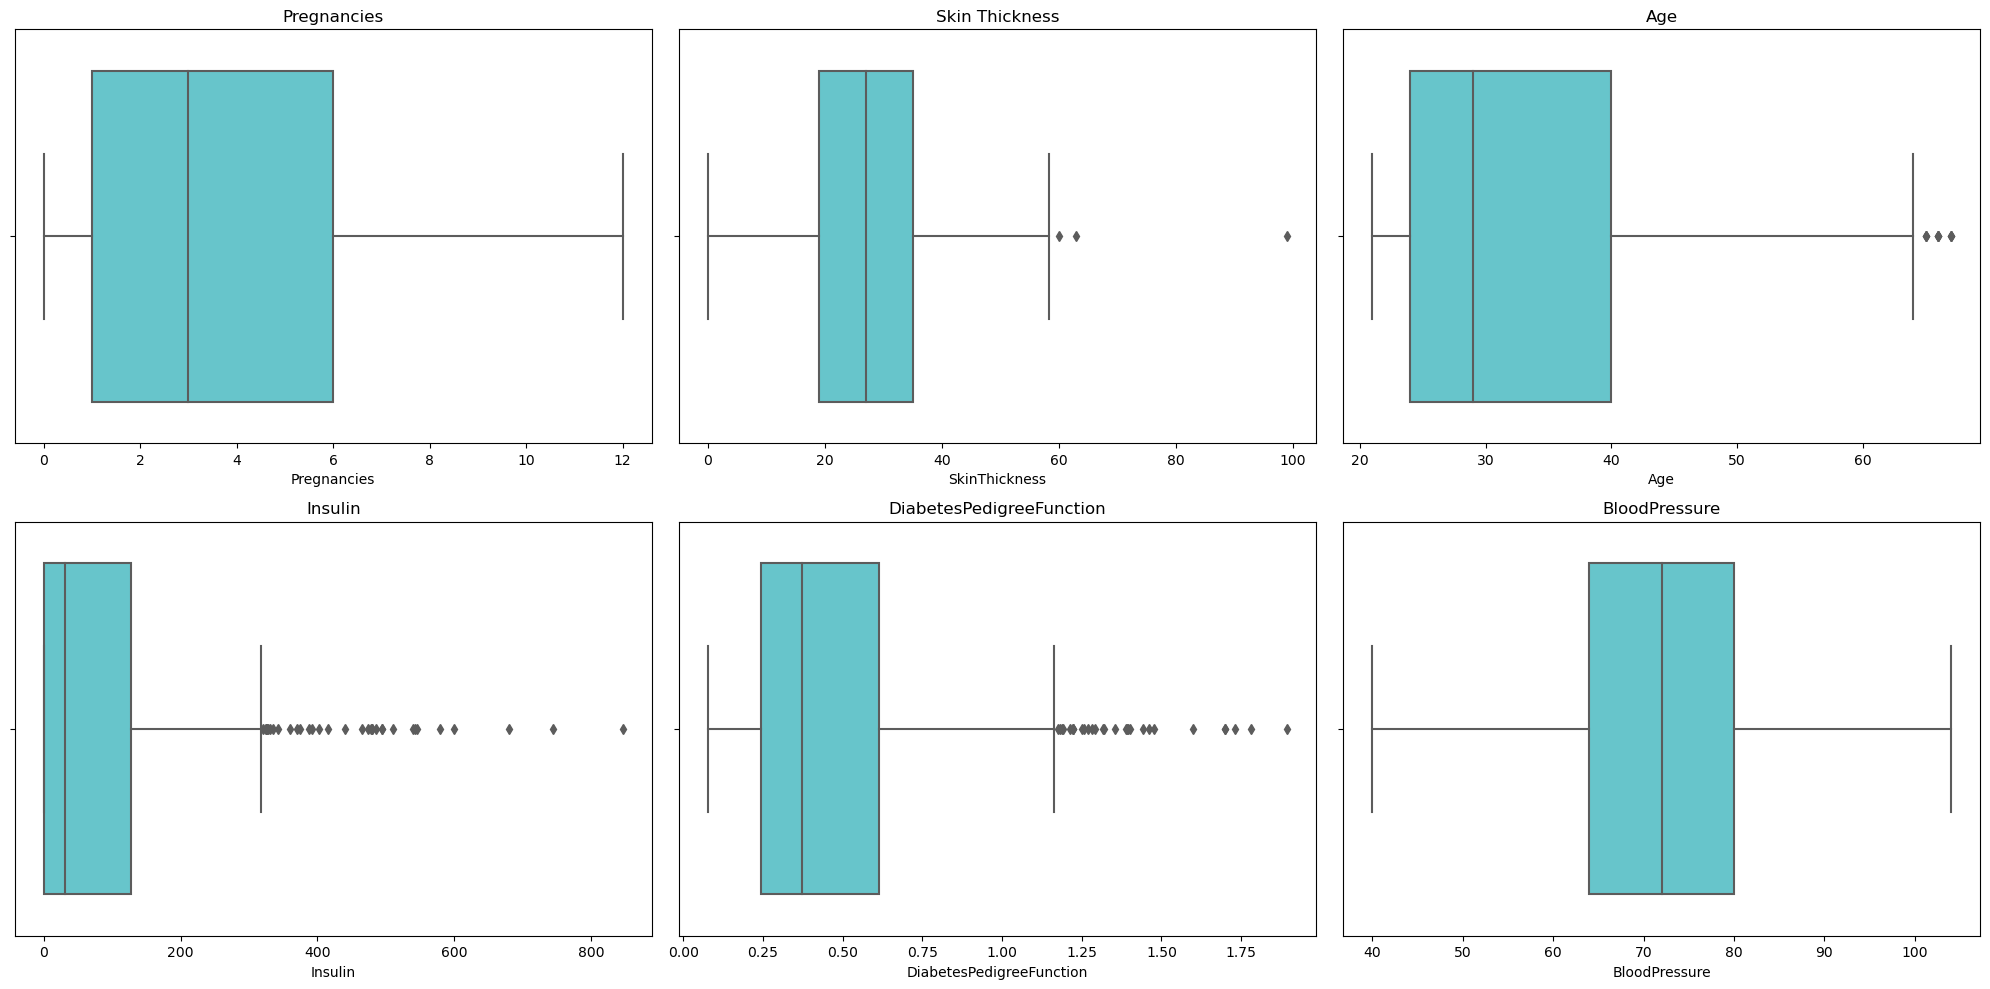

In [695]:
hls = sns.color_palette("hls")
blue = hls[3]
fig, axx = plt.subplots(2,3, figsize = (20,10))

axx[0,0].set_title('Pregnancies')
sns.boxplot(x = 'Pregnancies', data = diabetes, ax = axx[0,0], color = blue)

axx[0,1].set_title('Skin Thickness')
sns.boxplot(x = 'SkinThickness', data = diabetes, ax = axx[0,1], color = blue)

axx[0,2].set_title('Age')
sns.boxplot(x = 'Age', data = diabetes, ax = axx[0,2], color = blue)

axx[1,0].set_title('Insulin')
sns.boxplot(x = 'Insulin', data = diabetes, ax = axx[1,0], color = blue)

axx[1,1].set_title('DiabetesPedigreeFunction')
sns.boxplot(x = 'DiabetesPedigreeFunction', data = diabetes, ax = axx[1,1], color = blue)

axx[1,2].set_title('BloodPressure')
sns.boxplot(x = 'BloodPressure', data = diabetes, ax = axx[1,2], color = blue)

fig.set_facecolor('white')
plt.tight_layout()

Better visuals to interpret the data included the histograms, distribution curve and the scatterplots below. As we can see, most of the women had between 0-2 pregnancies, 30mm skin thickness, were 21-23 years old, had normal glucose levels (100-120 considered normal for non-diabetics) even with 0 micro U/L of insulin and normal blood pressure(between 80-120 mm Hg). Some of these numbers we would expect. One that really surprised me was the amount of zeros for insulin. I didn't find any information on whether the women fasted prior to being tested in which it would explain the lack of insulin.

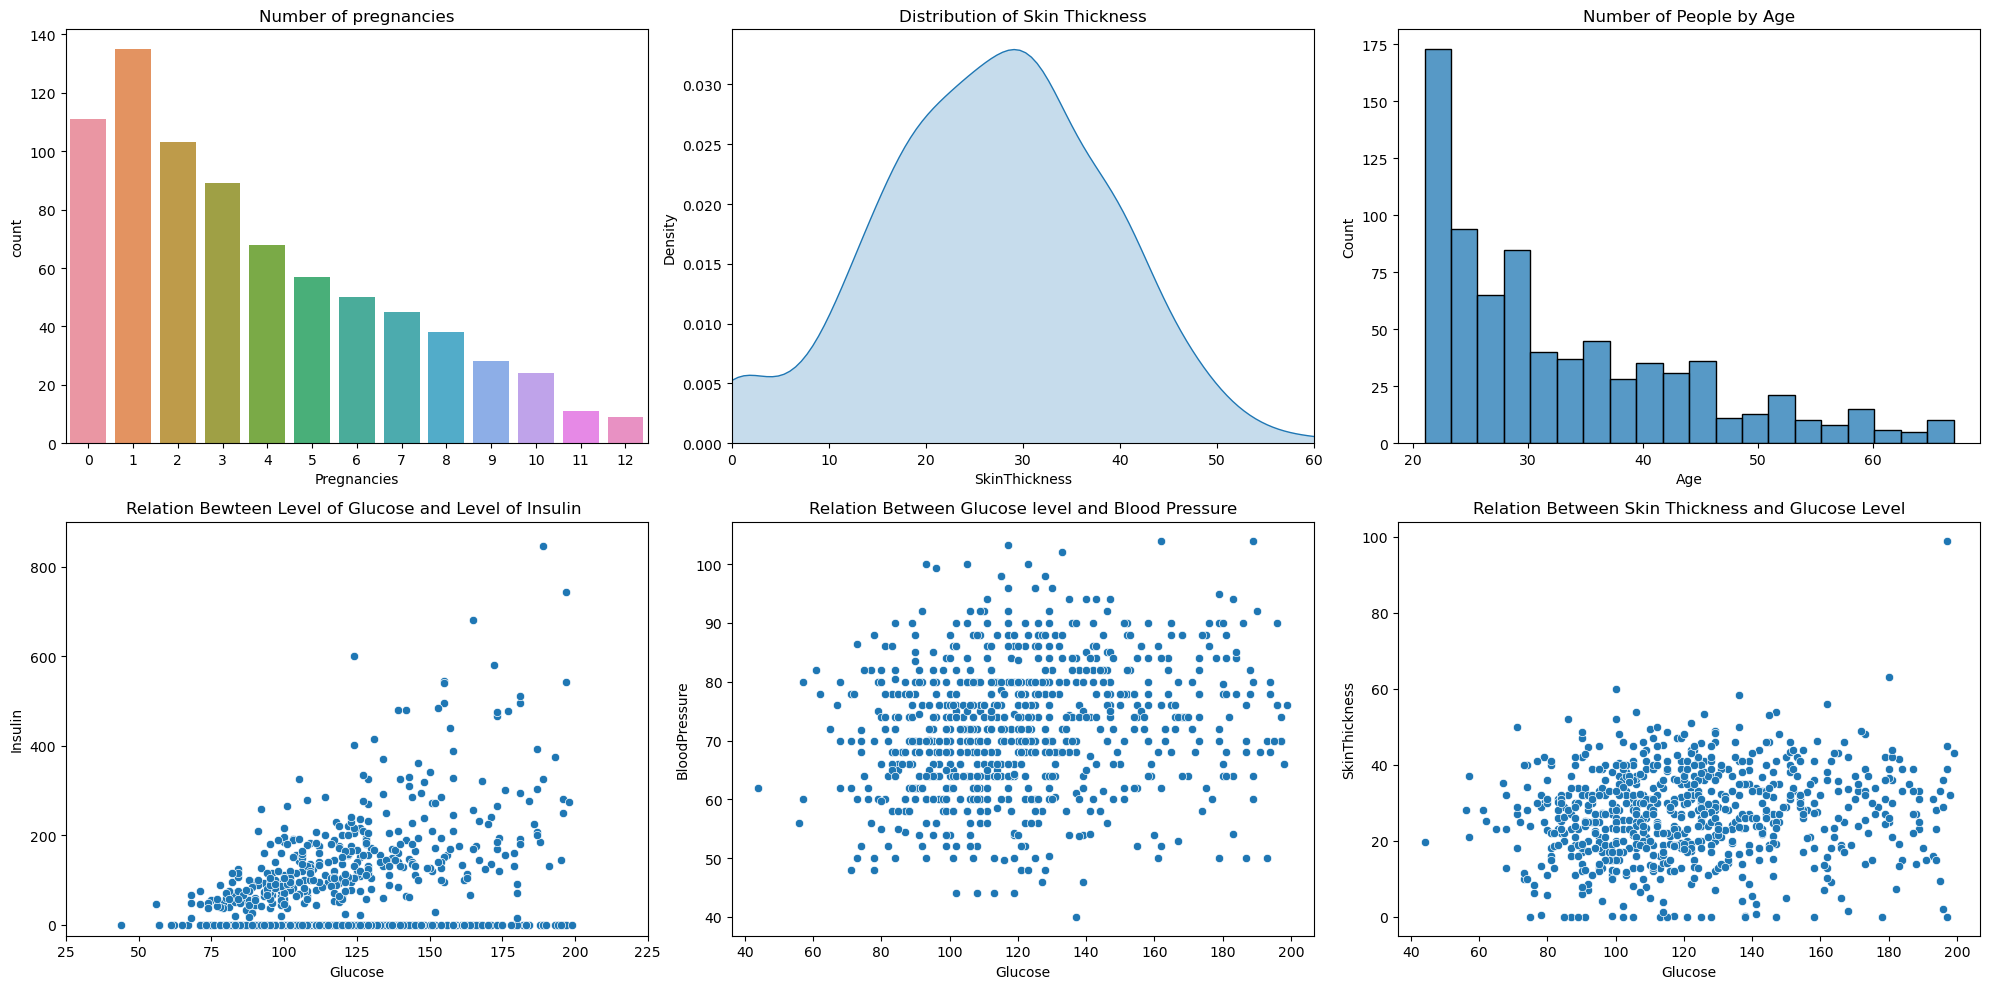

In [696]:
fig, axx = plt.subplots(2,3, figsize = (20,10))

axx[0,0].set_title('Number of pregnancies')
sns.countplot(x = 'Pregnancies', data = diabetes, ax = axx[0,0])

axx[0,1].set_title('Distribution of Skin Thickness')
sns.kdeplot(x = 'SkinThickness', data = diabetes, ax = axx[0,1], shade = True)
axx[0,1].set(xlim = (0,60))

axx[0,2].set_title('Number of People by Age')
sns.histplot(x = 'Age', data = diabetes, bins = 20, ax = axx[0,2])

axx[1,0].set_title('Relation Bewteen Level of Glucose and Level of Insulin ')
sns.scatterplot(x = 'Glucose', y = 'Insulin', data = diabetes, ax = axx[1,0])
axx[1,0].set_xlim(-25,225)
axx[1,0].set_ylim(-25,900)

axx[1,1].set_title('Relation Between Glucose level and Blood Pressure')
sns.scatterplot(x = 'Glucose', y = 'BloodPressure' , data = diabetes, ax = axx[1,1])

axx[1,2].set_title('Relation Between Skin Thickness and Glucose Level')
sns.scatterplot(x = 'Glucose', y = 'SkinThickness', data = diabetes, ax = axx[1,2])
axx[1,0].set_xlim(25,225)

fig.set_facecolor('white')
plt.tight_layout()

Below is the distribution of healthy people and diabetics among the different predictor variables. As we can see, there are many more healthy women than diabetics. The first thing that jumps out is that Glucose and Diabetic are positively correlated. Of all our predictor variables we would assume that glucose would be the most heavily weighted in determining who is diabetic. BMI and Age also seem to be slightly positively correlated as well.

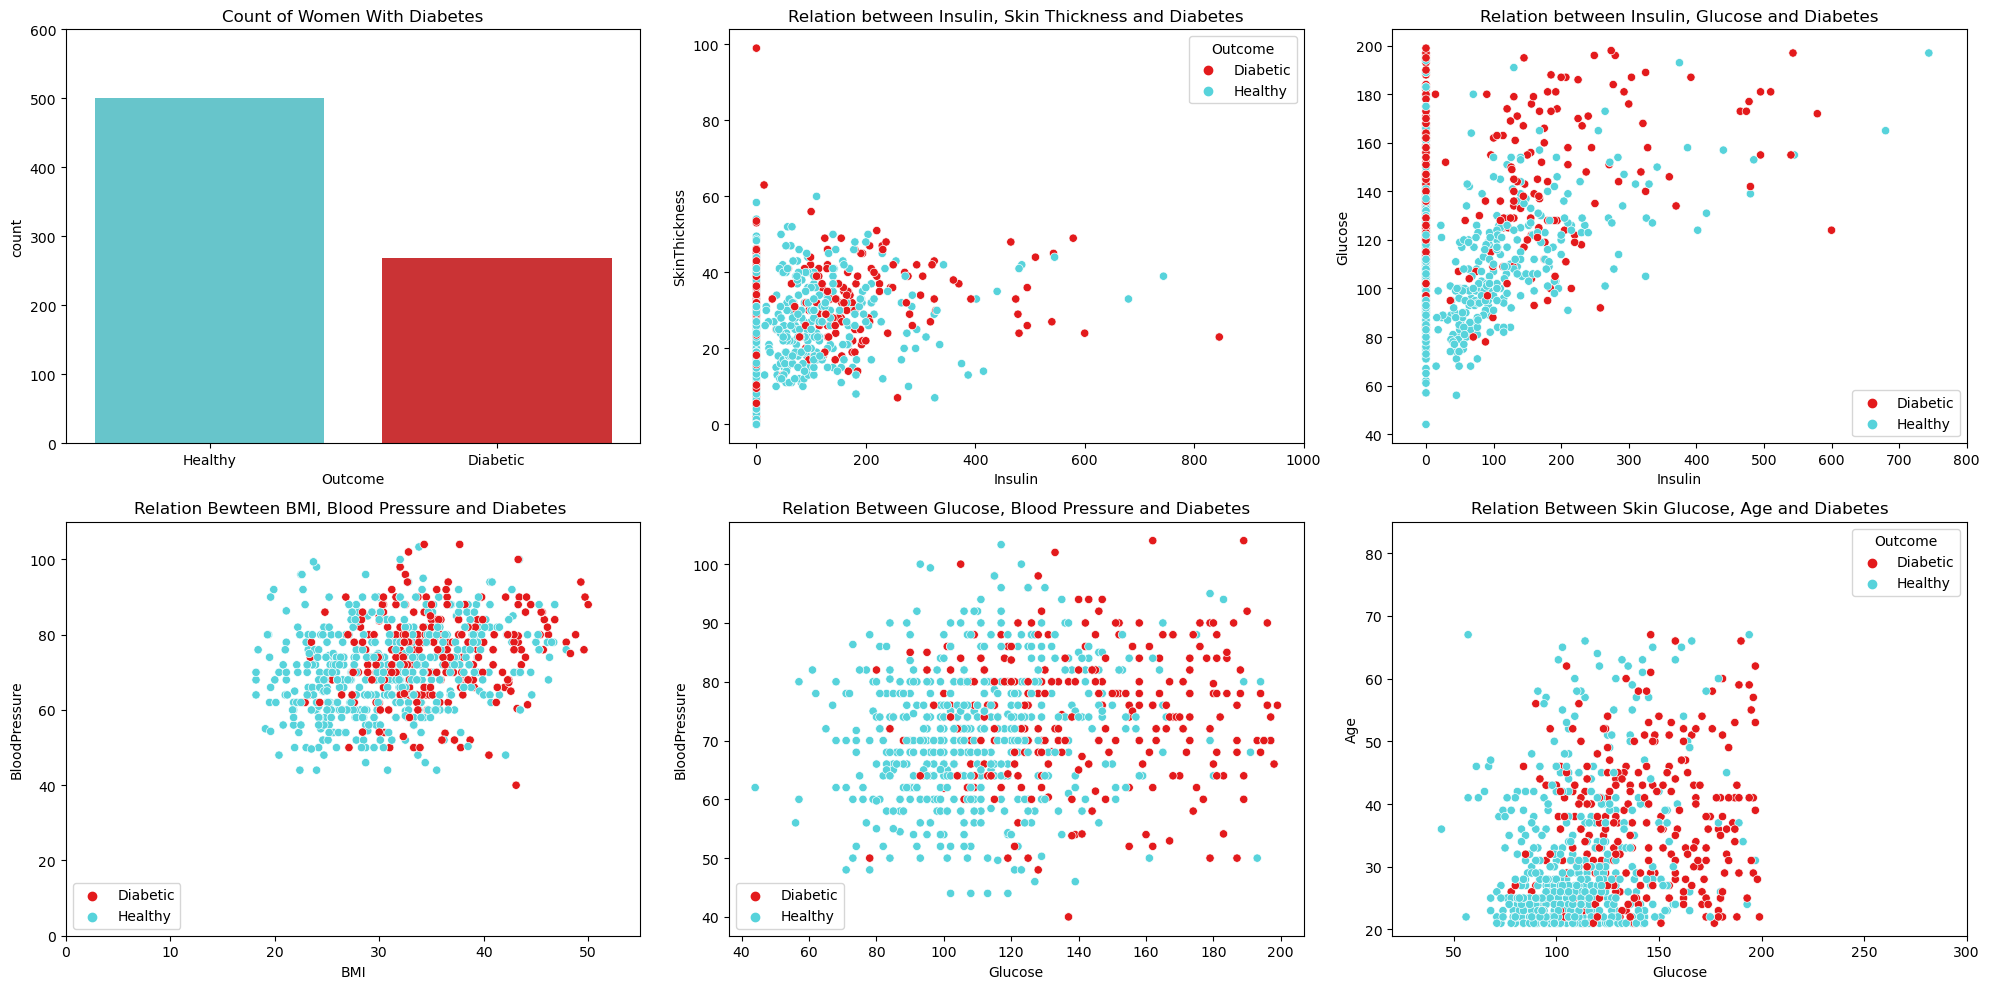

In [697]:
hls = sns.color_palette("hls")
pair = sns.color_palette('Paired')
hlsg = [hls[3], pair[5]]
hlsg_r = [pair[5], hls[3]]
legend_map = {0: 'Healthy', 1: 'Diabetic'}
fig, axx = plt.subplots(2,3, figsize = (20,10))

axx[0,0].set_title('Count of Women With Diabetes')
sns.countplot(x = 'Outcome', data = diabetes, ax = axx[0,0], palette = hlsg)
axx[0,0].set_xticklabels(['Healthy', 'Diabetic'])
axx[0,0].set_ylim(0,600)

axx[0,1].set_title('Relation between Insulin, Skin Thickness and Diabetes')
sns.scatterplot(x = 'Insulin', y = 'SkinThickness', hue = diabetes['Outcome'].map(legend_map), data = diabetes, ax = axx[0,1], palette = hlsg_r)
axx[0,1].set_xlim(-50,1000)

axx[0,2].set_title('Relation between Insulin, Glucose and Diabetes')
sns.scatterplot(x = 'Insulin', y ='Glucose', hue = diabetes['Outcome'].map(legend_map), data = diabetes, ax = axx[0,2], palette= hlsg_r).legend(loc = 'lower right')
axx[0,2].set_xlim(-50,800)

axx[1,0].set_title('Relation Bewteen BMI, Blood Pressure and Diabetes ')
sns.scatterplot(x = 'BMI', y = 'BloodPressure', hue = diabetes['Outcome'].map(legend_map), data = diabetes, ax = axx[1,0], palette = hlsg_r).legend(loc = 'lower left')
axx[1,0].set_xlim(0,55)
axx[1,0].set_ylim(0,110)

axx[1,1].set_title('Relation Between Glucose, Blood Pressure and Diabetes')
sns.scatterplot(x = 'Glucose', y = 'BloodPressure' , hue = diabetes['Outcome'].map(legend_map), data = diabetes, ax = axx[1,1], palette = hlsg_r).legend(loc = 'lower left')

axx[1,2].set_title('Relation Between Skin Glucose, Age and Diabetes')
sns.scatterplot(x = 'Glucose', y = 'Age', hue = diabetes['Outcome'].map(legend_map), data = diabetes, ax = axx[1,2], palette = hlsg_r)
axx[1,2].set_ylim(19,85)
axx[1,2].set_xlim(20, 300)
fig.set_facecolor('white')
plt.tight_layout()

Below is a heat map, showing the correlation of the different variables. As we can see Glucose is almost 20 percent more correlated to diabetes than BMI. Age and pregnancies seems to come in third and fourth as predictor variables.

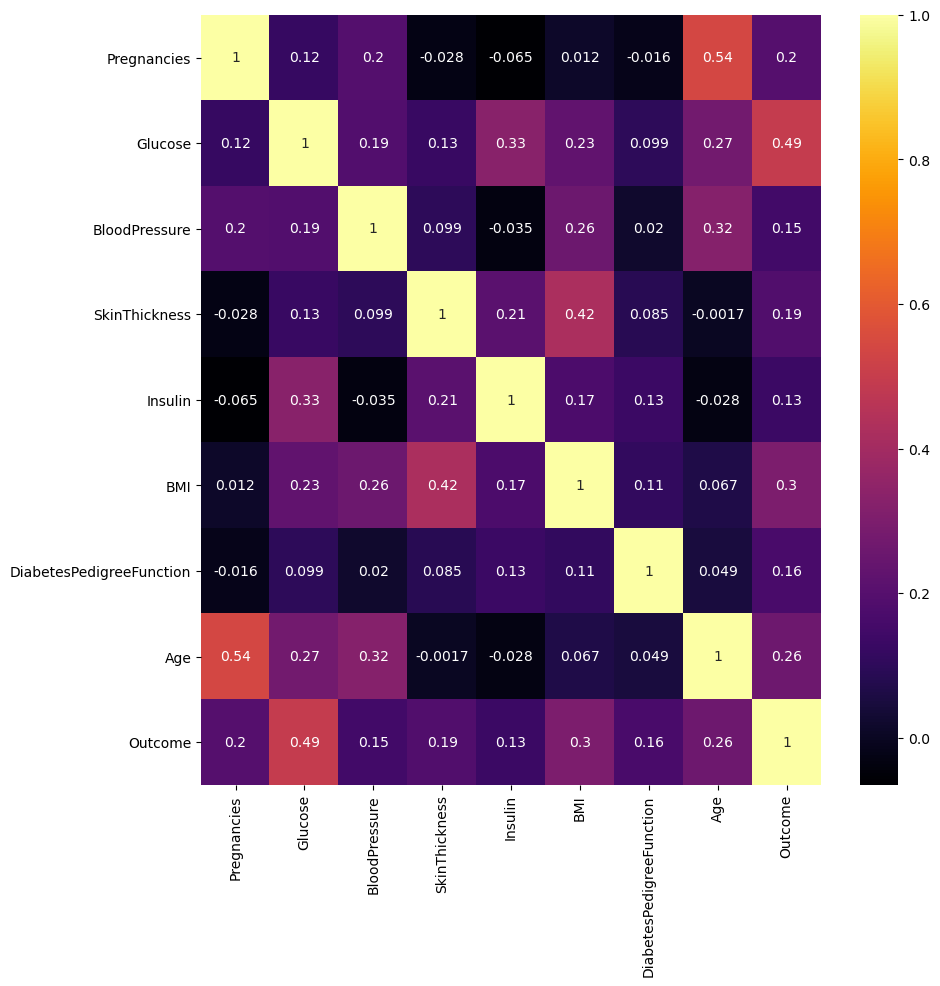

In [698]:
heat = plt.figure(figsize =(10,10))
sns.heatmap(diabetes.corr(), cmap = 'inferno', annot = True)
heat.set_facecolor('white')

Below we can see that it almost nice split of 65% healthy women vs. 35% diabetics.

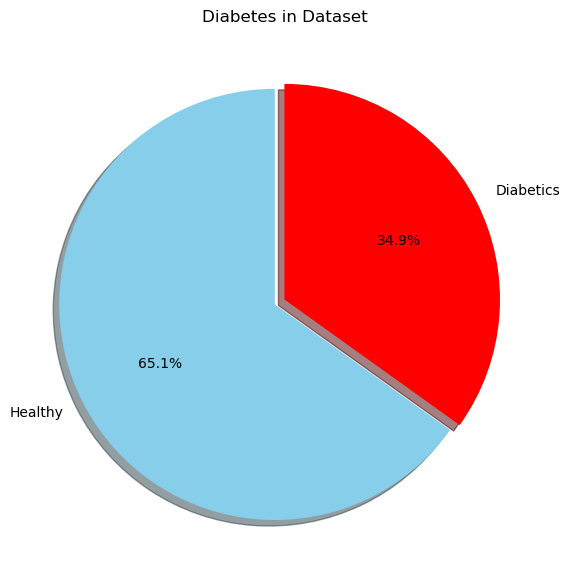

In [699]:
labels = ['Healthy', 'Diabetics']
sizes = diabetes['Outcome'].value_counts(sort = True)

colors = ['skyblue', 'red']
explode = (0.05, 0)

pie = plt.figure(figsize = (7,7))
plt.pie(sizes, explode = explode ,labels = labels, colors = colors, autopct = '%1.1f%%', shadow = True, startangle= 90)

pie.set_facecolor('white')
plt.title('Diabetes in Dataset')
plt.show()

Below in our overlapped historgram, it seems that the ratio of healthy to diabetic women really takes a turn after six pregnancies. We could infer that the risk for diabetes can go up after six pregnancies. After some external research, it has been found that 5%-10% of women have developed diabetes during a pregnancy. Given that insulin is a hormone and their bodies experience a huge change of many different hormones, it makes sense that the risk for diabetes is increased.

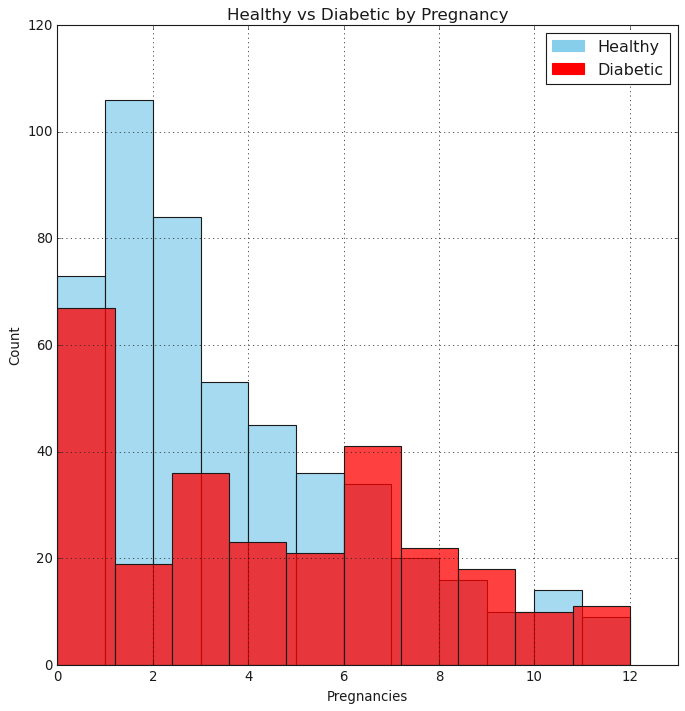

In [700]:
plt.style.use("classic")
bar1 = plt.figure(figsize = (10,10))

sns.histplot(diabetes[diabetes['Outcome'] == 0]['Pregnancies'], color = 'skyblue')
sns.histplot(diabetes[diabetes['Outcome'] == 1]['Pregnancies'], color = 'red')

plt.title('Healthy vs Diabetic by Pregnancy', fontsize = 15)
plt.xlim([0,13])
plt.grid(linewidth = 0.7)
red_patch = mpatches.Patch(color='red', label='Diabetic')
blue_patch = mpatches.Patch(color='skyblue', label='Healthy')
dat_legend = plt.legend(handles=[blue_patch, red_patch])
bar1.set_facecolor('white')
plt.show()

Here we can clearly see that women with higher glucose levels were more likely to be diabetic.

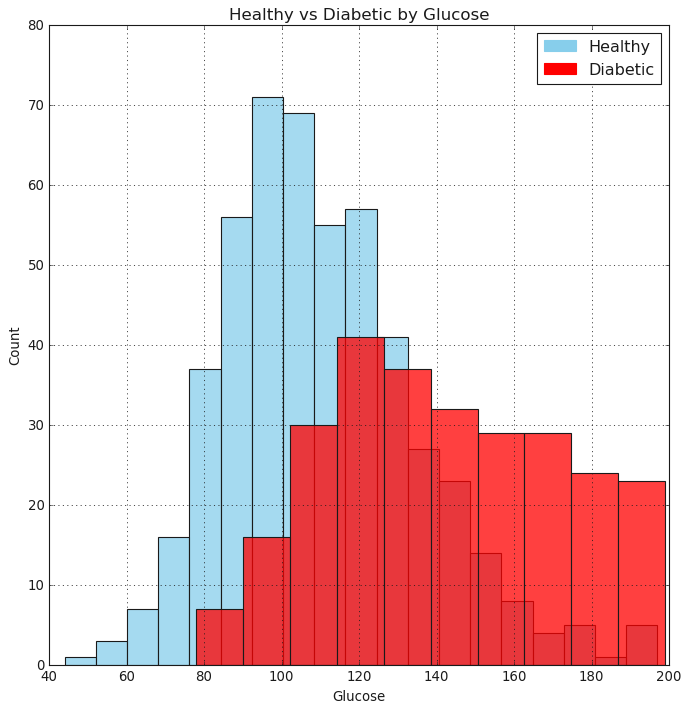

In [701]:
plt.style.use("classic")
bar2 = plt.figure(figsize = (10,10))

sns.histplot(diabetes[diabetes['Outcome'] == 0]['Glucose'], color = 'skyblue')
sns.histplot(diabetes[diabetes['Outcome'] == 1]['Glucose'], color = 'red')

plt.title('Healthy vs Diabetic by Glucose', fontsize = 15)
plt.grid(linewidth = 0.7)
plt.legend(handles=[blue_patch, red_patch])
bar2.set_facecolor('white')
plt.show()

Blood pressure doesn't seem to be correlated with detecting diabetes at least not at the age range in this study. Since most the largest count of women in this study were between the ages of 21-23 and we know that the health effects of diabetes are more long term, we would expect that women would not have drastically affected blood pressure even if they have diabetes.

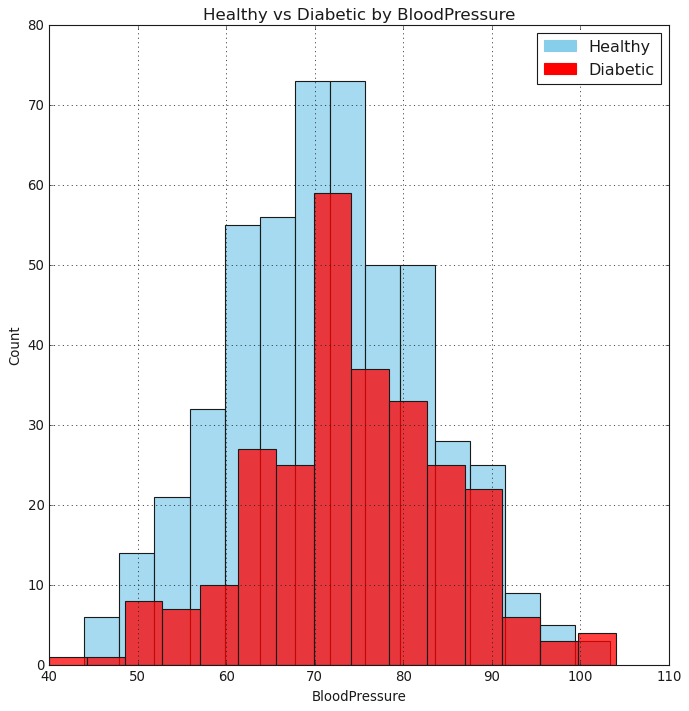

In [702]:
plt.style.use("classic")
bar3 = plt.figure(figsize = (10,10))

sns.histplot(diabetes[diabetes['Outcome'] == 0]['BloodPressure'], color = 'skyblue')
sns.histplot(diabetes[diabetes['Outcome'] == 1]['BloodPressure'], color = 'red')

plt.title('Healthy vs Diabetic by BloodPressure', fontsize = 15)
plt.grid(linewidth = 0.7)
plt.legend(handles=[blue_patch, red_patch])
bar3.set_facecolor('white')
plt.show()

I thought skin thickness would be a stronger predictor variable but it does not appear that it is. The values are plotted slightly to the right of healthy women but not by that much. There were a lot of 0 values for Skin Thickness that I replaced with a random distribution of values so our data might have looked a bit different, leaning towards thicker skin being more of a predictor for diabetes.

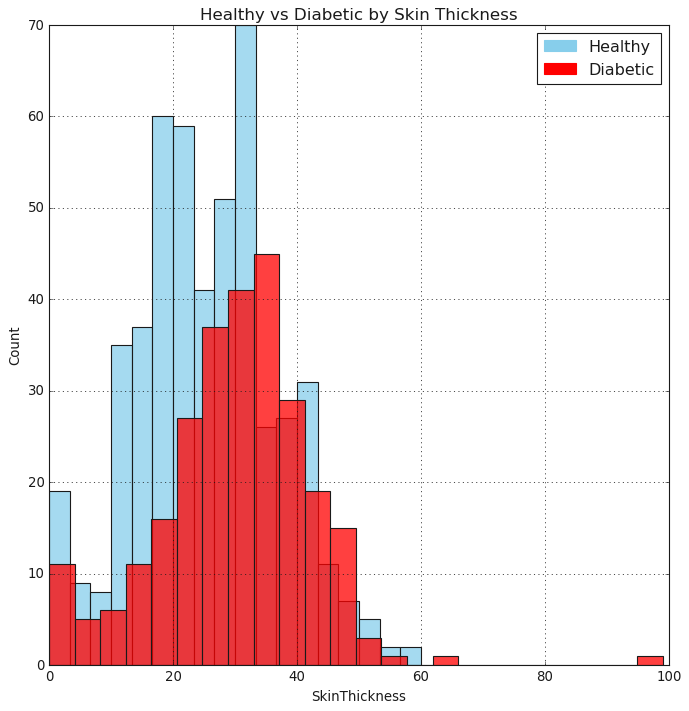

In [703]:
plt.style.use("classic")
bar4 = plt.figure(figsize = (10,10))

sns.histplot(diabetes[diabetes['Outcome'] == 0]['SkinThickness'], color = 'skyblue')
sns.histplot(diabetes[diabetes['Outcome'] == 1]['SkinThickness'], color = 'red')

plt.title('Healthy vs Diabetic by Skin Thickness', fontsize = 15)
plt.grid(linewidth = 0.7)
plt.legend(handles=[blue_patch, red_patch])
bar4.set_facecolor('white')
plt.show()

This histogram shows that there were much higher values for insulin in diabetics than there were in healthy women. I don't think that it will ultimately help us that much in predicting diabetics.

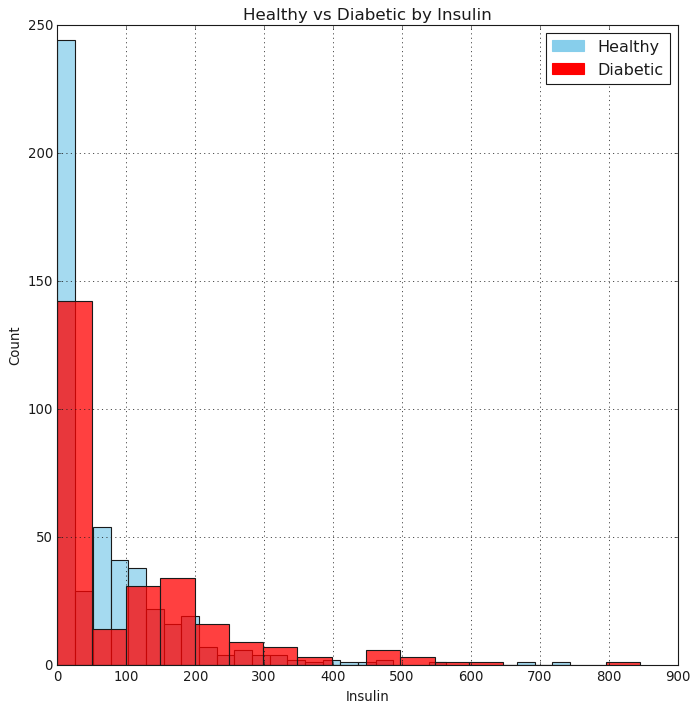

In [704]:
plt.style.use("classic")
bar5 = plt.figure(figsize = (10,10))

sns.histplot(diabetes[diabetes['Outcome'] == 0]['Insulin'], color = 'skyblue')
sns.histplot(diabetes[diabetes['Outcome'] == 1]['Insulin'], color = 'red')

plt.title('Healthy vs Diabetic by Insulin', fontsize = 15)
plt.grid(linewidth = 0.7)
plt.legend(handles=[blue_patch, red_patch])
bar5.set_facecolor('white')
plt.show()

We can clearly see that the BMI values for diabetics are plotted towards the higher BMI values, making this a clear predictor variable.

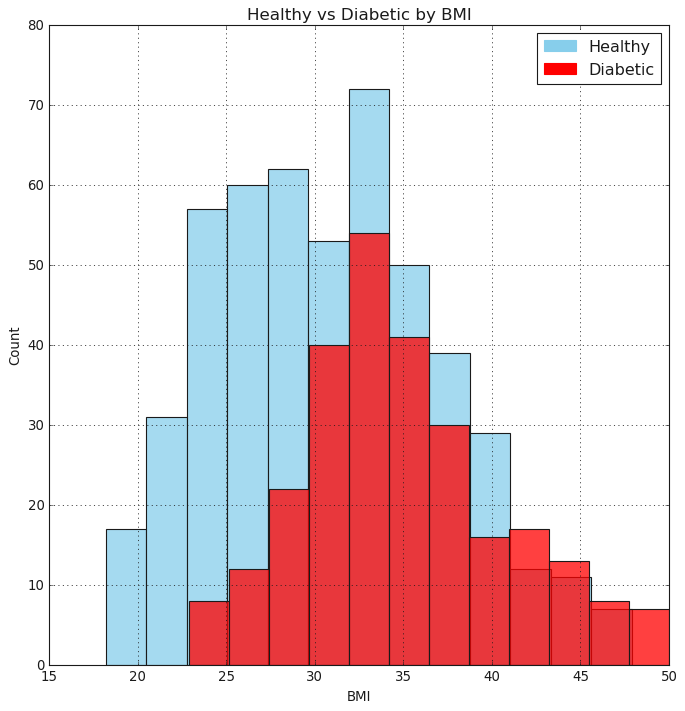

In [705]:
plt.style.use("classic")
bar6 = plt.figure(figsize = (10,10))

sns.histplot(diabetes[diabetes['Outcome'] == 0]['BMI'], color = 'skyblue')
sns.histplot(diabetes[diabetes['Outcome'] == 1]['BMI'], color = 'red')

plt.title('Healthy vs Diabetic by BMI', fontsize = 15)
plt.grid(linewidth = 0.7)
plt.legend(handles=[blue_patch, red_patch])
bar6.set_facecolor('white')
plt.show()

The Diabetes Pedigree Function values for diabetics seem to be consistently higher than those for healthy women. We can probably consider this useful data in predicting diabetics.

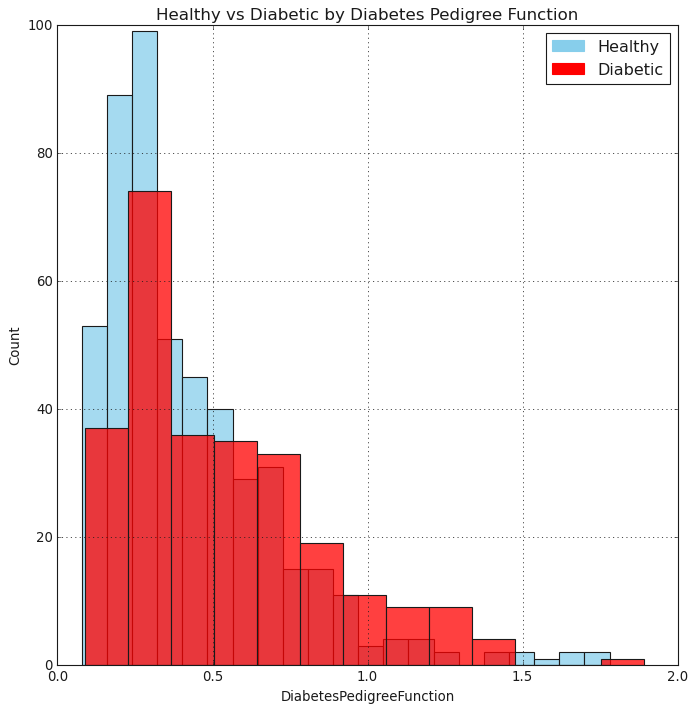

In [706]:
plt.style.use("classic")
bar7 = plt.figure(figsize = (10,10))

sns.histplot(diabetes[diabetes['Outcome'] == 0]['DiabetesPedigreeFunction'], color = 'skyblue')
sns.histplot(diabetes[diabetes['Outcome'] == 1]['DiabetesPedigreeFunction'], color = 'red')

plt.title('Healthy vs Diabetic by Diabetes Pedigree Function', fontsize = 15)
plt.grid(linewidth = 0.7)
plt.legend(handles=[blue_patch, red_patch])
bar7.set_facecolor('white')
plt.show()

As people age, their risk for diabetes seems to increase. Based on this data, you might infer that the type of diabetes found in these women was largely type 2 which tends to develop later in life. In contrast type 1 (Juvenile Diabetes) tends to occur before the age of 21. IN this study there were no women under the age of 21.

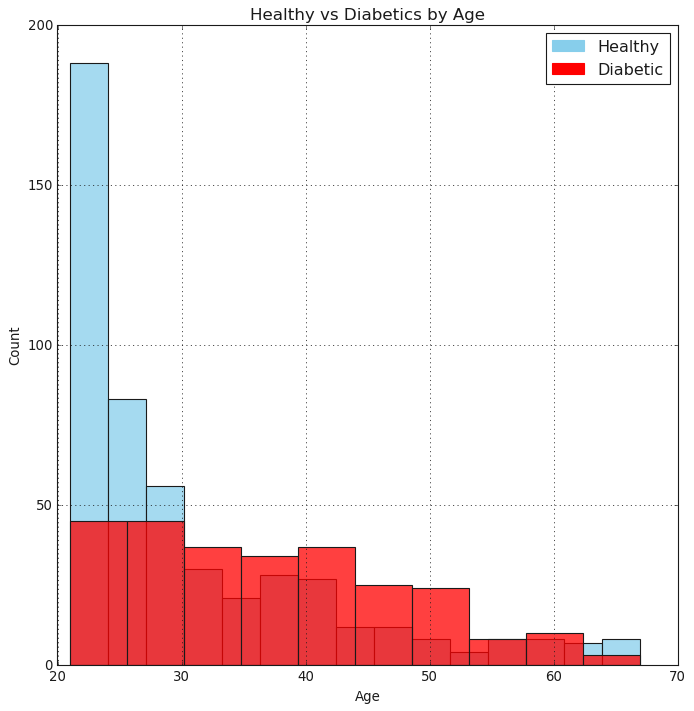

In [707]:
plt.style.use("classic")
bar8 = plt.figure(figsize = (10,10))

sns.histplot(diabetes[diabetes['Outcome'] == 0]['Age'], color = 'skyblue')
sns.histplot(diabetes[diabetes['Outcome'] == 1]['Age'], color = 'red')

plt.title('Healthy vs Diabetics by Age', fontsize = 15)
plt.grid(linewidth = 0.7)
plt.legend(handles=[blue_patch, red_patch])
bar8.set_facecolor('white')
plt.show()

In [708]:
importances = clf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

Below is a bar graph of the importance of our predictor variables. I don't quite agree with where 'Blood Pressure' is placed but nonetheless most of the predictor variables seem to be in the right place based on their importance.

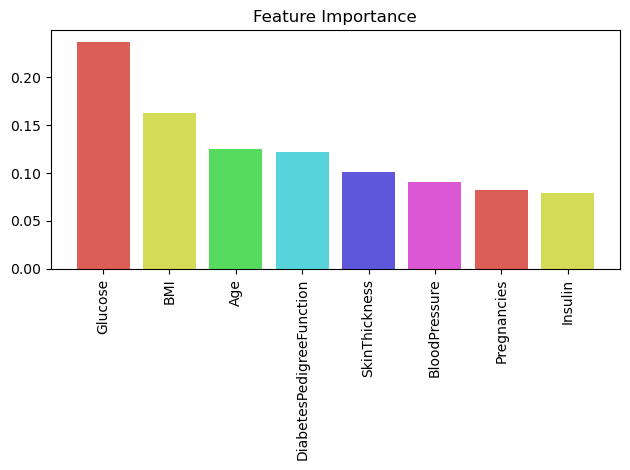

In [709]:
plt.rcParams.update(plt.rcParamsDefault)
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align = 'center', color = hls)
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation = 90)
plt.tight_layout()
plt.show()

Below, I assign the predictor variables and our dependent variable to X and y respectively and split the test and train groups from our diabetes dataset.

In [710]:
X = diabetes[['Glucose', 'Insulin', 'Age', 'Pregnancies', 'BloodPressure','DiabetesPedigreeFunction', 'SkinThickness', 'BMI']]
y = diabetes['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.29, random_state = 1)

The shape or our train and test datasets.

In [711]:
print("Number of Rows X_train dataset : ", X_train.shape)
print("Number of Rows y_train dataset : ", y_train.shape)
print("Number of Rows X_train dataset : ", X_test.shape)
print("Number of Rows y_train dataset : ", y_test.shape)

Number of Rows X_train dataset :  (545, 8)
Number of Rows y_train dataset :  (545,)
Number of Rows X_train dataset :  (223, 8)
Number of Rows y_train dataset :  (223,)


I used 11 different machine learning models below as well as used different metrics to assess the accuracy of those models. A detailed explanation of several of all the metrics and a few of the machine learning models is towards the end. Of all the models, I got the Random Forest Regressor, Adaboost and Gradient Boost Model to reach 80% accuracy! Just changing the random state until I got 80%, worked. These were also the two models that had quite a high standard deviation which isn't great but acceptable.

In [716]:
models = []
models.append(['Logistic Regression', LogisticRegression(random_state=0, max_iter = 300)])
models.append(['Random Forest Regressor',RandomForestClassifier(n_estimators = 106, random_state = 1)])
models.append(['SVM', SVC(random_state=5)])
models.append(['KNeighbors', KNeighborsClassifier()])
models.append(['GaussianNB', GaussianNB()])
models.append(['BernoulliNB', BernoulliNB()])
models.append(['Decision Tree', DecisionTreeClassifier(random_state=5)])
models.append(['Extra Tree', ExtraTreesClassifier(random_state=5)])
models.append(['AdaBoost', AdaBoostClassifier(random_state=5)])
models.append(['Gradient Boost', GradientBoostingClassifier(random_state=5)])
models.append(['Light GBM', LGBMClassifier(random_state=5)])


lst_1= []

for m in range(len(models)):
    lst_2= []
    model = models[m][1]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)  #Confusion Matrix
    accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)   #K-Fold Validation
    roc = roc_auc_score(y_test, y_pred)  #ROC AUC Score
    precision = precision_score(y_test, y_pred)  #Precision Score
    recall = recall_score(y_test, y_pred)  #Recall Score
    f1 = f1_score(y_test, y_pred, zero_division = 0)  #F1 Score
    print(models[m][0],':')
    print(cm)
    print('Accuracy Score: ',accuracy_score(y_test, y_pred))
    print('')
    print("K-Fold Validation Mean Accuracy: {:.2f} %".format(accuracies.mean()*100))
    print('')
    print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
    print('')
    print('ROC AUC Score: {:.2f}'.format(roc))
    print('')
    print('Precision: {:.2f}'.format(precision))
    print('')
    print('Recall: {:.2f}'.format(recall))
    print('')
    print('F1: {:.2f}'.format(f1))
    print('-----------------------------------')
    print('')
    lst_2.append(models[m][0])
    lst_2.append((accuracy_score(y_test, y_pred))*100) 
    lst_2.append(accuracies.mean()*100)
    lst_2.append(accuracies.std()*100)
    lst_2.append(roc)
    lst_2.append(precision)
    lst_2.append(recall)
    lst_2.append(f1)
    lst_1.append(lst_2)

Logistic Regression :
[[128  14]
 [ 31  50]]
Accuracy Score:  0.7982062780269058

K-Fold Validation Mean Accuracy: 76.52 %

Standard Deviation: 5.06 %

ROC AUC Score: 0.76

Precision: 0.78

Recall: 0.62

F1: 0.69
-----------------------------------

Random Forest Regressor :
[[122  20]
 [ 24  57]]
Accuracy Score:  0.8026905829596412

K-Fold Validation Mean Accuracy: 76.34 %

Standard Deviation: 5.71 %

ROC AUC Score: 0.78

Precision: 0.74

Recall: 0.70

F1: 0.72
-----------------------------------

SVM :
[[132  10]
 [ 44  37]]
Accuracy Score:  0.757847533632287

K-Fold Validation Mean Accuracy: 73.76 %

Standard Deviation: 5.53 %

ROC AUC Score: 0.69

Precision: 0.79

Recall: 0.46

F1: 0.58
-----------------------------------

KNeighbors :
[[119  23]
 [ 28  53]]
Accuracy Score:  0.7713004484304933

K-Fold Validation Mean Accuracy: 68.46 %

Standard Deviation: 6.27 %

ROC AUC Score: 0.75

Precision: 0.70

Recall: 0.65

F1: 0.68
-----------------------------------

GaussianNB :
[[121  21

C:\Users\wally\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Extra Tree :
[[126  16]
 [ 31  50]]
Accuracy Score:  0.7892376681614349

K-Fold Validation Mean Accuracy: 76.16 %

Standard Deviation: 5.61 %

ROC AUC Score: 0.75

Precision: 0.76

Recall: 0.62

F1: 0.68
-----------------------------------

AdaBoost :
[[126  16]
 [ 28  53]]
Accuracy Score:  0.8026905829596412

K-Fold Validation Mean Accuracy: 72.31 %

Standard Deviation: 6.60 %

ROC AUC Score: 0.77

Precision: 0.77

Recall: 0.65

F1: 0.71
-----------------------------------

Gradient Boost :
[[127  15]
 [ 27  54]]
Accuracy Score:  0.8116591928251121

K-Fold Validation Mean Accuracy: 76.90 %

Standard Deviation: 5.42 %

ROC AUC Score: 0.78

Precision: 0.78

Recall: 0.67

F1: 0.72
-----------------------------------

Light GBM :
[[115  27]
 [ 28  53]]
Accuracy Score:  0.7533632286995515

K-Fold Validation Mean Accuracy: 73.78 %

Standard Deviation: 5.92 %

ROC AUC Score: 0.73

Precision: 0.66

Recall: 0.65

F1: 0.66
-----------------------------------



Below is a table of all the models and their respective metrics for accuracy and as we can see Gradient Boose and Random Forest performed the best.

In [717]:
model_accuracy_df = pd.DataFrame(lst_1, columns= ['Model', 'Accuracy', 'K-Fold Mean Accuracy', 'Std. Deviation', 'ROC AUC', 'Precision', 'Recall', 'F1'])
model_accuracy_df.sort_values(by= ['Accuracy', 'K-Fold Mean Accuracy'], inplace= True, ascending= False)
model_accuracy_df

,Model,Accuracy,K-Fold Mean Accuracy,Std. Deviation,ROC AUC,Precision,Recall,F1
9,Gradient Boost,81.165919,76.902357,5.421252,0.780516,0.782609,0.666667,0.720000
1,Random Forest Regressor,80.269058,76.343434,5.713343,0.781429,0.740260,0.703704,0.721519
8,AdaBoost,80.269058,72.313131,6.600513,0.770822,0.768116,0.654321,0.706667
0,Logistic Regression,79.820628,76.515152,5.062864,0.759346,0.781250,0.617284,0.689655
7,Extra Tree,78.923767,76.158249,5.613501,0.752304,0.757576,0.617284,0.680272
4,GaussianNB,78.026906,73.609428,6.817143,0.753217,0.716216,0.654321,0.683871
3,KNeighbors,77.130045,68.457912,6.268919,0.746175,0.697368,0.654321,0.675159
2,SVM,75.784753,73.760943,5.531671,0.693184,0.787234,0.456790,0.578125
10,Light GBM,75.336323,73.784512,5.923347,0.732090,0.662500,0.654321,0.658385
6,Decision Tree,73.094170,65.700337,6.597712,0.698574,0.643836,0.580247,0.610390


I decided to take a closer look at the Random Forest Classifier and plot the ROC and Precision Recall curves as well as the confusion matrix in the form of a heat map. A deeper explanation of these metrics are at the end of this post. By all accounts we seem to have a pretty good model for predicting diabetes from given these predictor variables. While 100% is the goal, 80% is pretty good.

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       142
           1       0.74      0.70      0.72        81

    accuracy                           0.80       223
   macro avg       0.79      0.78      0.78       223
weighted avg       0.80      0.80      0.80       223

ROC AUC Score: 0.8659363588941054
Accuracy: 0.8026905829596412


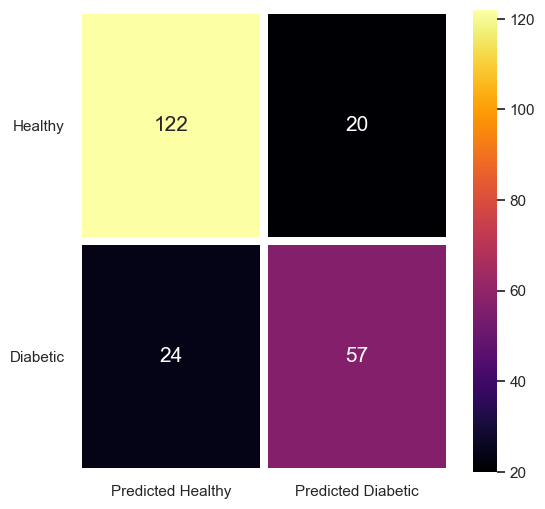

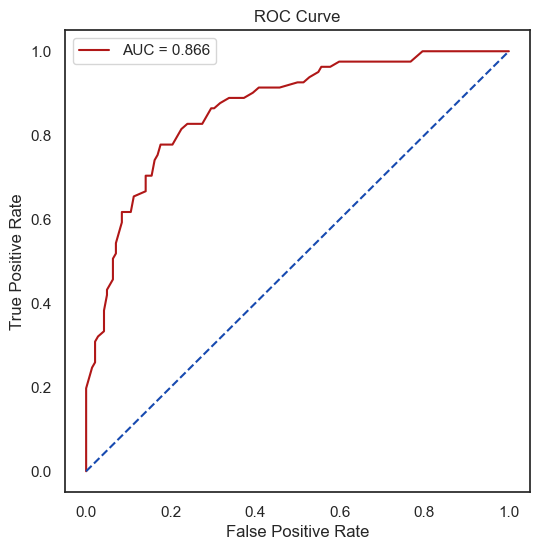

<Figure size 600x600 with 0 Axes>

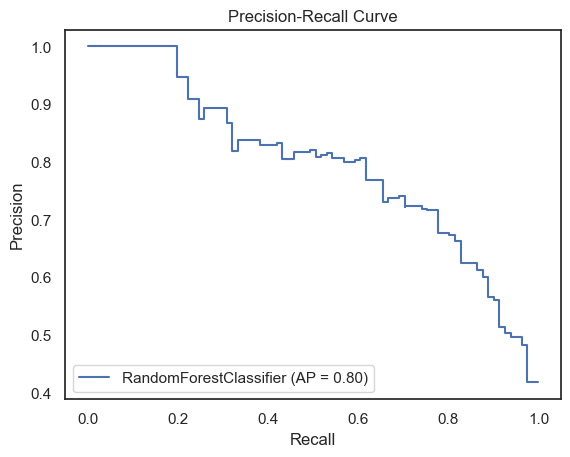

In [718]:
clf = RandomForestClassifier(n_estimators = 106, random_state = 1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

y_prob = clf.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC Score: {roc_auc_score(y_test, y_prob)}')
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

plt.figure(figsize = (6,6))
sns.heatmap(cm, cmap = 'inferno', annot = True, fmt = 'd', linewidths = 5, cbar = True, annot_kws = {'fontsize': 15}, yticklabels= ['Healthy','Diabetic'], xticklabels= ['Predicted Healthy', 'Predicted Diabetic'])
plt.yticks(rotation = 0)
plt.show()

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (6,6))
plt.plot(false_positive_rate, true_positive_rate, color = '#b01717', label = 'AUC = %0.3f'% roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

plt.figure(figsize = (6,6))
average_precision = average_precision_score(y_test, y_prob)
disp = plot_precision_recall_curve(clf, X_test, y_test)
plt.title('Precision-Recall Curve')
plt.show()

So, I ran all of these machine learning models and that's great. Other than look up a collection of other people's code and making modifications where I needed to, I don't know too much about these models except for the Random Forest Regressor, Support Vector Model and Logistic Regression. Below I explain the differences between different models and give detailed explanations about the all the different metrics used to evaluate these models.

After learning more about machine learning models, it was difficult to think of a real life example that didn't involved datasets. This is mainly due to the fact that machine learning models, learn by analyzing by hundreds of rows of data. So trying to explain them using a simple example like I tried to haphazardly in this actually tried to compare separating lemons to Support Vector Machines. Let me know if my analogy works in my last [post](https://github.com/wallywanderlust/wallylearnspython/blob/146f2ed9ebebcef0da4f1a56a436892a4b31885b/Titanic%20Revised.ipynb)
However, here is what I did learn this week.


After some reading, it was interesting to find out that a lot of these machine learning models are very similar. For example, I think I can say that Gradient Boost, AdaBoost, LightGBM (Gradient Boosting Machine) and XG Boost (which I wasn't able to successfully load) are all part of the same family. In fact the way in which the models predict outcomes is similar to Decision Trees and Random Forest. There are two main differences.

In simple terms, boosting refers to building several single models from a dataset and combining them into a composite model that ultimately makes it stronger in terms of being able to predict outcomes. Below I use the example of a Gradient Boost Model.

1. The way the trees are built
2. The way the results are combined

Let's address the first difference. The trees in a Gradient Boost Model are built off of each other. They build one tree, analyze the accuracy of that tree and then attempt to build the next tree, trying to improve upon the errors of the previous tree. The next tree then tries to improve on the tree before it. Instead of building it's trees simulatneously without 'communication' between each tree (Random Forest Model), the intent of a Gradient Boost Model is to build a tree and then avoid the previous trees' mistakes when building the next tree.

The second difference is that in a Random Forest Model, each tree has a vote, independent and without bias of the other trees of the weights in which each predictor variable should have. Then all those votes are calculated to give the proper importance values for the independent variables.
In a Gradient Boost Model, the results are combined along the way. So, because of that it is constantly updating it's final conclusion of the various weights that the independent variables have on the outcome. This is what I've understood and while trying to continuously improve upon the model at every iteration seems like it would be more efficient, there are some drawbacks.

1. If there are a lot of predictor variables that don't help you accurately make predictions otherwise known as noise, this will contribute to your Gradient Boost Model being more susceptible for overfitting.

Because the Gradient Boost Model is only trying to improve on the previous tree, it doesn't have trees in it's forest that have taken a sample of the predictor variables that may not include noise, it will include some noise in it's prediction, therefore giving unnecessary weight to predictor variables that may have less weight on actually predicting outcomes. Gradient Boost Models tend to work better on data with less noise.

2. 2. To run this model takes much more time than does a Random Forest model.
A Random Forest Model generates it's trees simultaneously, independent of other trees. A Gradient Boost Model needs to 'communicate' with the tree before it so it can improve upon the results of that tree. Imagine that you have a big project at work that requires the man power of 200 people. In one scenario all 200 workers have individual parts that can be done without each other (Random Forest). In another scenario, one person starts the project, finishes and then the next person tries to improve that project (Gradient Boost). That project will in most cases be better because all 200 workers have looked at that project but each time the project is worked on, there are 199 people doing nothing so it will obviously take much longer. Also, using this example, if it gets to worker 10 and there's something in the project that isn't really needed(noise), it's unlikely that worker 10 will remove it if 9 other people thought it was fine to be there. This useless part of the project will ultimately affect the accuracy of what the project was trying to achieve.


As far as the differences between all the boosting models (i.e. xgboost, adaboost, lightGBM) I think I'll need some time to understand all the nuances. For now, in my mind, I've put all these models in a certain family. As I was reading different blog posts, I found this mind map that confirmed my hypothesis. 

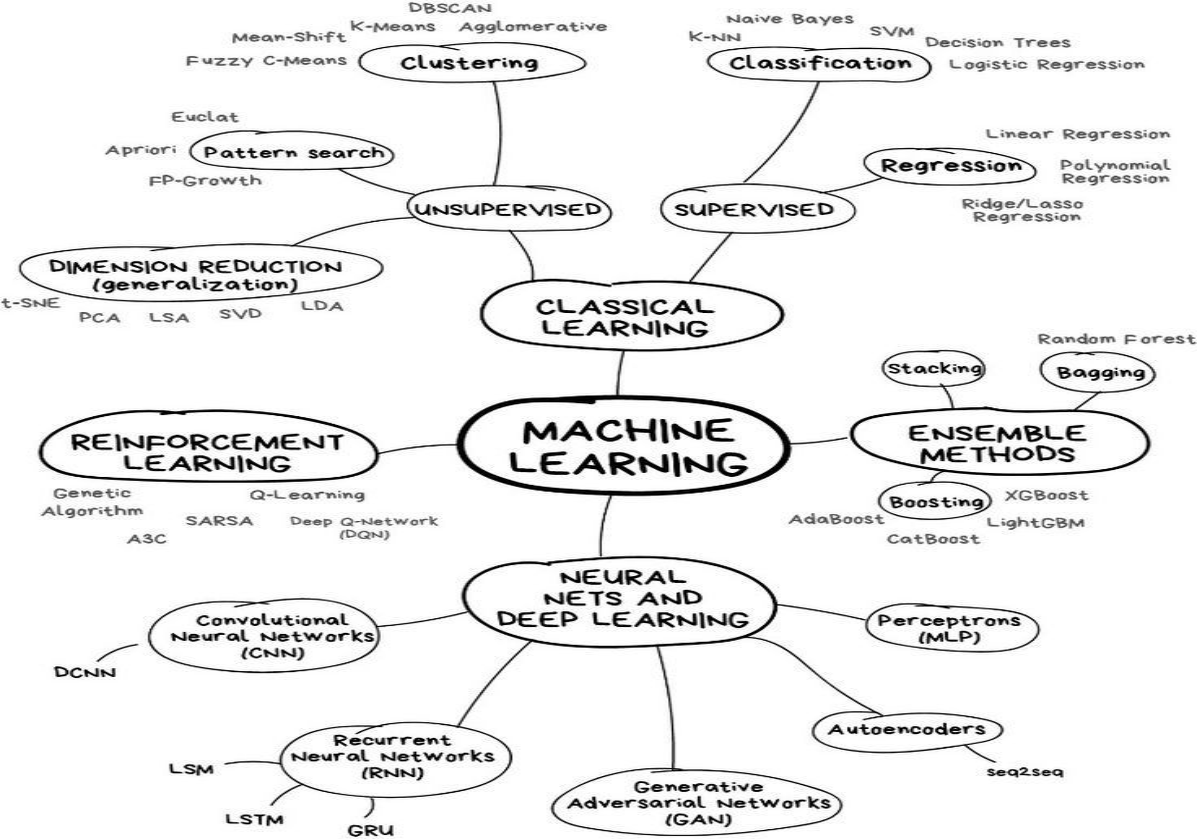

Rather than try to explain all the machine learning models I read about and used. I'm going to go on to the ways of evaluating the accuracy of the models. I felt like I understood these different scores pretty well.

One of the important accuracy scores I used was the ROC AUC score which stands for Receiver Operator Characteristics Area Under the Curve.

A ROC AUC score determines how well a machine learning model differentiates people as (in the case of my project this week) diabetic or healthy. Thus, the score is based on how many of those predictions your model got right. What is also taken into consideration is the four classes that those predictions go into; True Positive, False Positive, True Negative and False Negative.

True Positive (TP): Diabetic women who were predicted to be diabetic

False Positive (FP): Healthy women who were predicted to be diabetic

True Negative (TN): Healthy women who were predicted to be healthy

False Negative (FN): Diabetic women who were predicted to be healthy

A curve is plotted on a graph where the True Positive Rate (what percentage of diabetic women predicted to be diabetic that your model spit out of all the women who were diabetic (TP/(TP + FN))) is represented on the Y-axis and the False Positive Rate (what percentage of healthy women predicted to be diabetic that your model spit out of all the healthy women(FP/(TN + FP))). The area under that curve is the ROC AUC score. The higher score, the better the model. 1 would be your model predicting everything correctly. 0.5 would be your model only predicting half of them right and thus being useless because we could just flip a coin and do just as well. 0 would be your model being able to separate all the data into two piles of diabetic and healthy women but saying all the healthy women are diabetic and all diabetic women are healthy, which is interesting but not something you would build on purpose.

An F1 score calculates accuracy in a slightly different way. It uses terms of precision and recall.

Precision is the ratio of true positives among all positives as defined by the results and the your model. TP/(TP + FP)

Recall is the ratio of number of true positives among the true positives and false negatives. TP/(TP + FN)) Essentially the True Positive Rate.

Now, there is a formula
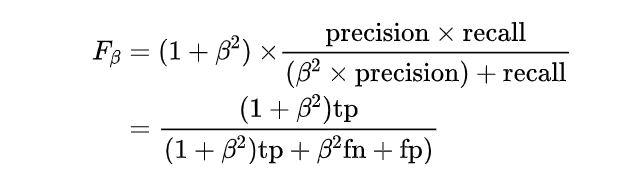

This calculates the F1 score. The only variable in that equation that you are not familiar with is β. This is a variable that you can change the value of to indicate how much more important recall is than precision. In this case if we changed β to 2 then we are saying that recall is twice as important as precision and it becomes a F2 score that we are calculating. So why is it important if our model says that a woman is healthy but she is diabetic or a woman is diabetic but she is healthy, both are wrong. 

Well in the situation where your model predicted that the woman was diabetic and she turned out to be healthy, she likely got much more medical attention, more tests were done and it was a happy surprise that she wasn't diabetic. The alternative is your model predicting that a woman is healthy and she is in fact diabetic. She goes for an unknown amount of time with a chronic disease that goes untreated and continues to affect her health. One outcome is clearly less desirable than another. In this case having poor recall is much more devastating than having poor precision and thus we would most likely change score our model with something closer to an F2 score than an F1 score.

As with the ROC AUC score, the higher the score, the better the model. Subsequently, our precision and recall scores are included in my analysis and the higher they are, the better they are. The recall score is always going to be lower than the precision score.

A K-Fold Validation Mean Accuracy is essentially taking your training data for your machine model, splitting (or folding) it into k subsets (normally 10) and training the model on nine of the subsets and using the 10th subset as the test subset. The training on the 9 subsets and then testing of the test subset will give an accuracy score. This continues until all 10 subsets have been the test subset and there are 10 scores. These scores are averaged and then that is your K-Fold Validation Mean Accuracy.

A standard deviation score should be interpreted like this. I took the standard deviation of the K-Fold Validation Mean Accuracy. This means that of the 10 percentage accuracies of the performance of the 10 subsets for each machine learning model. Their accuracy had a standard deviation of 5.71 percentage points for the Random Forest Model for example. Given the 68–95–99.7 rule, roughly 7 of the 10 subsets had an accuracy score within 5.71 percentage points from the K-Fold Validation Mean Accuracy which was 74.14. So basically about 7 of the 10 subsets were in the 68%-80% accuracy range. What does this mean? Ideally we would like our results to have a lower standard deviation because then there would be more confidence in that result but ultimately it is not catastrophic for us to have a higher standard deviation.

In my project there were also two curves that I plotted for each ML model. The ROC AUC curve and the Precision Recall curve. I've touched on both of these concepts quickly but I wanted to explain the curves.

For the ROC curve the x-axis is the False Positive Rate and the y-axis is the True Positive Rate. Through common sense we want our percentage of False Positives to be 0 percentage and would like our True Positive percentage to be 100. Thus our goal is to have a ROC curve that is a 90 degree angle where the intersection of the perpendicular lines is (0,1). The AUC or the Area Under the Curve would then be equal to 1. The dotted line is at .5 where our model would amount to the predictive capablitities of a coin flip and therefore would be useless.

In the Precision Recall Curve (PR Curve) our x-axis is the Recall (True Positive Rate, our y-axis for the ROC curve) and our y-axis values, Precision (percentage of True Positives among True and False Positives). We don't want any false positives so we want this to be 100 percent as well. Therefore the goal is to have the intersection of the perpendicular lines to be at (1,1).
Below are two examples of the ideal ROC curve and Precision Recall Curve.

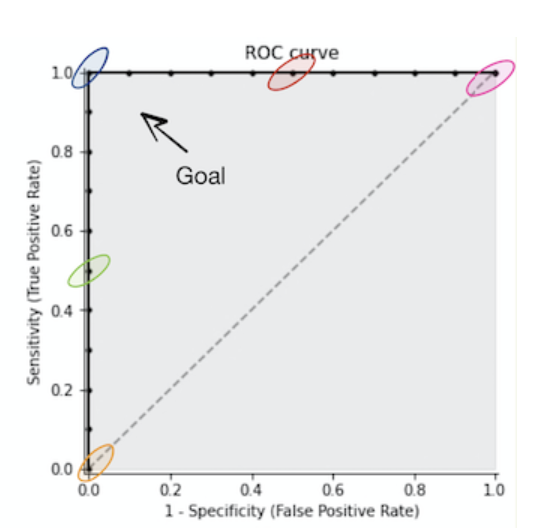

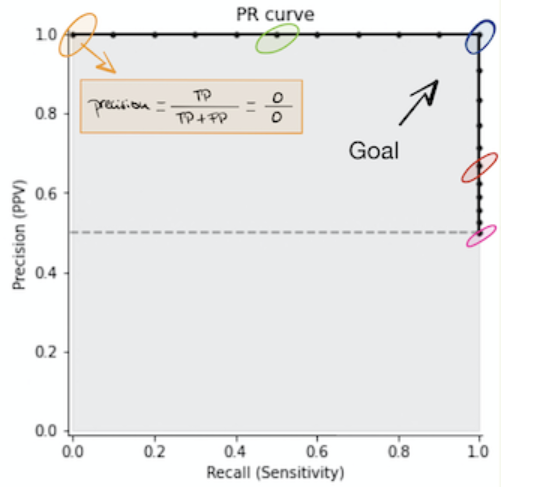

The last metric that I wanted to mention here and perhaps the clearest and easiest to read after my explanation is a confusion matrix. A confusion matrix is a 2 x 2 table that has the counts for all four possible outcomes for your ML models; True Positive, False Positive, False Negative and True Negative. You want your lowest counts to be in the top right and bottom left boxes, leaving top left and bottom right to be your highest counts.

I put a lot more work into this project this week but really enjoyed it. Learning about the different machine learning models, the metrics to score them and doing it on a project about identifying diabetes was personally relevant to me because I am type 1 diabetic. If there are any ways that I can improve my code, please let me know in the issues section. Other than that, thanks for reading and I'm looking forward to my next post! -Walter